In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np

torch.manual_seed(4)
np.random.seed(4)

In [26]:
# from data_utils.DataloadersFactory import fix_train_val_split
# fix_train_val_split()

In [3]:
%autoreload 2
from Trainer import Trainer
trainer = Trainer(GOLD_METRIC=5e-5)

C:\Users\ilya\AppData\Local\Programs\Python\Python38\lib\site-packages\torchaudio\extension\extension.py:13: UserWarning: torchaudio C++ extension is not available.
  warnings.warn('torchaudio C++ extension is not available.')


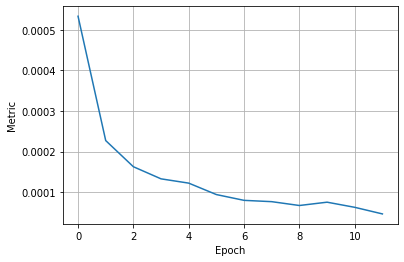

END OF EPOCH 11


In [28]:
model, history = trainer.train("model")

# Distilation

Оказалось, что если поучить модель с `hidden_size` уменьшенным в два раза немного дольше, то можно добиться такого же качества как и в исходной моделе, не прибегая ни к каким трюкам.

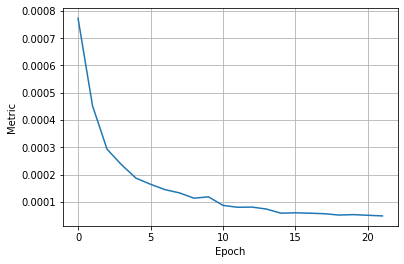

END OF EPOCH 21


In [29]:
trainer.train("small_model_32");

После уменьшения `hidden_size` еще в два раза, просто обучить модель до нужного качества уже не получалось, поэтому была добавлена дистиляция из оригинальной модели.

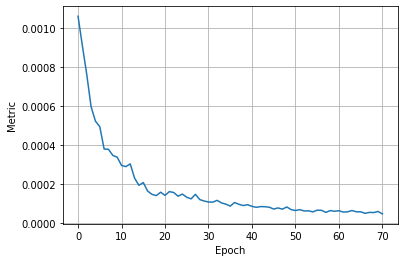

END OF EPOCH 70


In [30]:
trainer.train("small_model_16", teacher_name="model");

Можно свертки тоже подвигать:

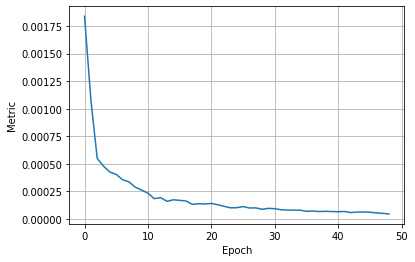

END OF EPOCH 48


In [4]:
trainer.train("small_model_16x4", teacher_name="model");

# Attention distilation

Дистиляцию атеншена мне показалось логичным сделать просто на случайных данных. Не уверен, что я все правильно понял, но вроде сработало.

In [83]:
def distile_attention(teacher, student, config):
    loss = 10
    opt = torch.optim.Adam(student.parameters(), lr=1e-3)
    for epoch in range(1000):
        opt.zero_grad()
        batch = torch.rand((256, 144, config.hidden_size))*1000
        batch = batch.to(config.device)
        logits_t = torch.softmax(teacher(batch)/10, -2)
        logits_t.detach()
        logits_s = torch.softmax(student(batch), -2)
        loss = -(logits_t * logits_s).sum(dim=-2).mean()
        loss.backward()
        opt.step()

    print(f"{loss:.010f}")

In [84]:
from models.CRNN import Attention
teacher = trainer.restore_model("model")
student = Attention(teacher.config.hidden_size, teacher.config.hidden_size//2)
distile_attention(teacher.attention, student, teacher.config)
teacher.attention = student
trainer.save_model(teacher, "model_da")
teacher.eval()

model_da = teacher

-0.0104460958


In [85]:
teacher = trainer.restore_model("small_model_16")
student = Attention(teacher.config.hidden_size, teacher.config.hidden_size//2)
distile_attention(teacher.attention, student, teacher.config)
teacher.attention = student
trainer.save_model(teacher, "small_model_16_da")
teacher.eval()

small_model_16_da = teacher

-0.0087500028


In [86]:
teacher = trainer.restore_model("small_model_16x4")
student = Attention(teacher.config.hidden_size, teacher.config.hidden_size//2)
distile_attention(teacher.attention, student, teacher.config)
teacher.attention = student
trainer.save_model(teacher, "small_model_16x4_da")
teacher.eval()

small_model_16x4_da = teacher

-0.0132533051


# Quantization

С квантизацией я попробовал три сетапа: квантизацию оригинальной модели, квантизацию дистилированной модели и квантизацию моделей с дистилированным атеншн. Все в `int8`. 

In [87]:
import torch.quantization
import torch.nn as nn

model_fp32 = trainer.restore_model("model")
model_int8 = torch.quantization.quantize_dynamic(
    model_fp32, {nn.GRU, nn.Linear, nn.Conv2d}, dtype=torch.qint8
)
model_int8.eval()
trainer.save_model(model_int8, "model_int8")

In [88]:
model_fp32 = model_da
model_int8 = torch.quantization.quantize_dynamic(
    model_fp32, {nn.GRU, nn.Linear, nn.Conv2d}, dtype=torch.qint8
)
model_int8.eval()
trainer.save_model(model_int8, "model_da_int8")

In [89]:
small_model_16_fp32 = trainer.restore_model("small_model_16")
small_model_16_int8 = torch.quantization.quantize_dynamic(
    small_model_16_fp32, {nn.GRU, nn.Linear, nn.Conv2d}, dtype=torch.qint8
)
small_model_16_int8.eval()
trainer.save_model(small_model_16_int8, "small_model_16_int8")

In [90]:
small_model_16_fp32 = small_model_16_da
small_model_16_int8 = torch.quantization.quantize_dynamic(
    small_model_16_fp32, {nn.GRU, nn.Linear, nn.Conv2d}, dtype=torch.qint8
)
small_model_16_int8.eval()
trainer.save_model(small_model_16_int8, "small_model_16_da_int8")

In [91]:
small_model_16x4_fp32 = trainer.restore_model("small_model_16x4")
small_model_16x4_int8 = torch.quantization.quantize_dynamic(
    small_model_16x4_fp32, {nn.GRU, nn.Linear, nn.Conv2d}, dtype=torch.qint8
)
small_model_16x4_int8.eval()
trainer.save_model(small_model_16x4_int8, "small_model_16x4_int8")

In [92]:
small_model_16x4_fp32 = small_model_16x4_da
small_model_16x4_int8 = torch.quantization.quantize_dynamic(
    small_model_16x4_fp32, {nn.GRU, nn.Linear, nn.Conv2d}, dtype=torch.qint8
)
small_model_16x4_int8.eval()
trainer.save_model(small_model_16x4_int8, "small_model_16x4_da_int8")

# Pruning

Я пытался вырезать зануленные веса, но потом сдался :') Торч сам по себе умеет только маскировать, даже при структурнос прунинге, насколько я разобрался.

In [5]:
# import torch.nn.utils.prune as prune

# model_pruned = trainer.restore_model("model")
# prune.ln_structured(model_pruned.conv[0], name="weight", amount=0.5, n=2, dim=0)
# dict(model_pruned.named_parameters()).keys()
# prune.remove(model_pruned.conv[0], 'weight')
# dict(model_pruned.named_buffers()).keys()
# mask = (model_pruned.conv[0].weight != 0).all(dim=-1).all(dim=-1).all(dim=-1)
# model_pruned.conv[0].weight.data = model_pruned.conv[0].weight[mask]
# model_pruned.conv[0].bias.data = model_pruned.conv[0].bias[mask]
# model_pruned.gru.input_size = model_pruned.conv_out_frequency * 4
# model_pruned(torch.zeros(1, TaskConfig.n_mels, 100))
# trainer.save_model(model_pruned, "model_pruned")

# Evaluation

In [93]:
%autoreload 2
from Evaluator import Evaluator
evaluator = Evaluator(5e-5)
evaluator.evaluate("model")
evaluator.evaluate("small_model_32")
evaluator.evaluate("small_model_16")
evaluator.evaluate("small_model_16x4")
evaluator.evaluate("model_da", model=model_da)
evaluator.evaluate("small_model_16_da", model=small_model_16_da)
evaluator.evaluate("small_model_16x4_da", model=small_model_16x4_da)
evaluator.evaluate("model_int8", model=model_int8, original_model_name="model")
evaluator.evaluate("small_model_16_int8", model=small_model_16_int8, original_model_name="small_model_16")
evaluator.evaluate("small_model_16x4_int8", model=small_model_16x4_int8, original_model_name="small_model_16x4")
evaluator.evaluate("model_da_int8", model=model_int8, original_model_name="model_da")
evaluator.evaluate("small_model_16_da_int8", model=small_model_16_int8, original_model_name="small_model_16_da")
evaluator.evaluate("small_model_16x4_da_int8", model=small_model_16x4_int8, original_model_name="small_model_16x4_da")

102it [00:05, 17.60it/s]
102it [00:05, 19.20it/s]
102it [00:05, 18.59it/s]
102it [00:05, 20.30it/s]
102it [00:05, 18.66it/s]
102it [00:05, 20.28it/s]
102it [00:05, 19.35it/s]
102it [00:06, 16.90it/s]
102it [00:05, 18.46it/s]
102it [00:05, 18.84it/s]
102it [00:05, 17.43it/s]
102it [00:05, 19.39it/s]
102it [00:05, 19.36it/s]


,MACS,Memory (KB),Metric,Model,Real Time (CPU),Compression rate,Speed up rate,Metric decay rate
0,70443.0,280.420898,0.000046,model,0.002229,1.00,1.00,1.00
1,25387.0,104.420898,0.000049,small_model_32,0.002139,0.37,0.36,1.05
2,10539.0,46.420898,0.000048,small_model_16,0.002187,0.17,0.15,1.04
3,6679.0,31.358398,0.000046,small_model_16x4,0.001875,0.11,0.09,0.98
4,68331.0,272.170898,0.000049,model_da,0.001885,0.97,0.97,1.05
5,10395.0,45.795898,0.000060,small_model_16_da,0.002374,0.16,0.15,1.29
6,6535.0,30.733398,0.000049,small_model_16x4_da,0.002158,0.11,0.09,1.05
7,70443.0,81.592773,0.000049,model_int8,0.001404,0.29,1.00,1.06
8,10539.0,21.217773,0.000061,small_model_16_int8,0.001204,0.08,0.15,1.31
9,6679.0,16.280273,0.000049,small_model_16x4_int8,0.001553,0.06,0.09,1.05


Я прошу прощения за нейминг. Логика у него следующая:

- model -- базовая модель
- small_* -- дистиляция
- *_int8 -- квантизация
- *_da -- (от лат. distilation attention) дистиляция аттеншэна

In [94]:
# import pandas as pd
# pd.DataFrame({
# 'model'   : ["model","small_model_32","small_model_16","small_model_16x4","model_int8"  ,"small_model_16_int8"      ,"small_model_16x4_int8"    ],
# 'methode' : ["-"    ,"-"             ,"distillation"  ,"distillation"    ,"quantization","distillation+quantization","distillation+quantization"]
# })

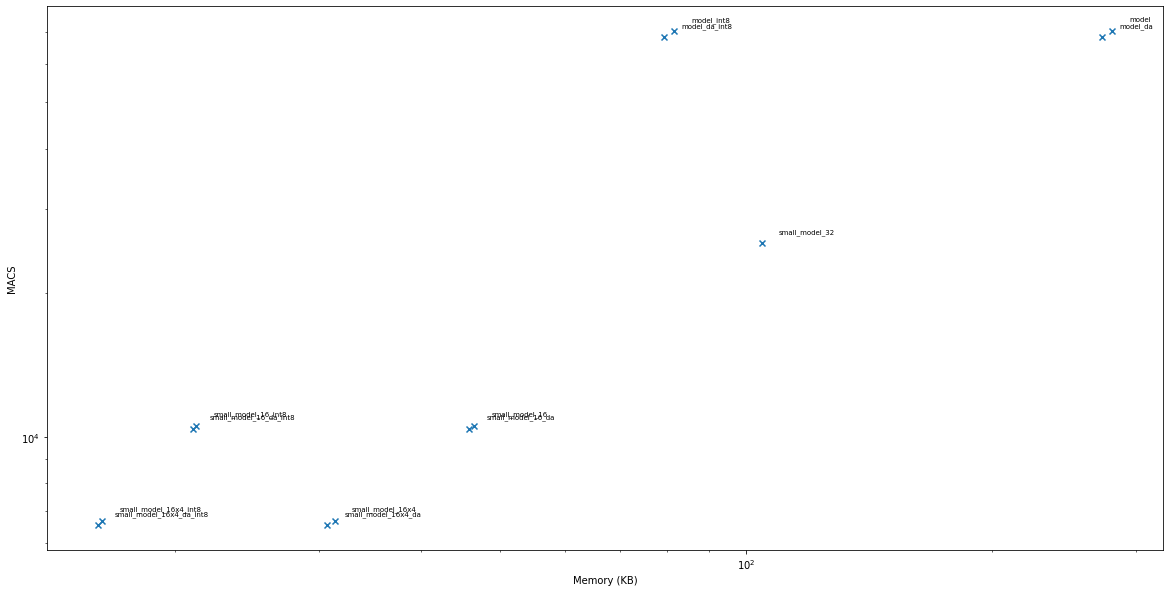

In [97]:
evaluator.visualize()

Я проше прощения за кривую верстку графика, но нормально что-то не понимаю как делать, слишком близко и далеко одновременно точки.

Какие выводы можно сделать?

Победила дистиляция + квантизация + дистиляция атеншена

Самый большой вклад за обычной дистиляцией.

Дистиляция атеншена сработало хорошо (хотя и не сильно уменьшила модель) в двух случаях, но сильно просадила качество в третьем, что странно.

Во преки моим ожиданиям, квантизация не просадила качество почти совсем, и позволила добить уменьшение модели, хотя и не повлияла на скорость.

# Streaming

Стриминг такой вот. В него можно сувать последовательность любой длины, он посчитает сколько сможет новых конволюций (с учетом оригинального страйда, то есть каждый раз ждем stride новых наблюдений), потом засунет все это в гру, соеденит с буфером и посчитает атеншн. Вроде работает.

In [ ]:
from models.StreamingCRNN import StreamingCRNN
from config import configs
step = 8
streaming_model = StreamingCRNN(configs["model"], 10, step)
streaming_model = trainer.restore_model("model", streaming_model)
streaming_model.eval();

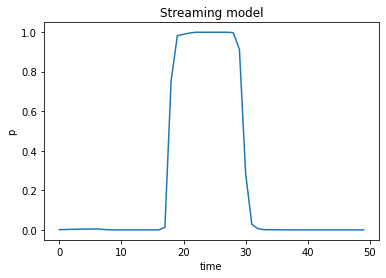

In [ ]:
import matplotlib.pyplot as plt
batch, labels = next(iter(trainer.train_loader))
for i in range(labels.size(0)):
    if labels[i] == 0:
        neg_idx = i
    else:
        pos_idx = i
batch = batch[[neg_idx, pos_idx, neg_idx, neg_idx]]
batch = trainer.melspec_val(batch)
batch = batch.transpose(0, 1).flatten(start_dim=1)
outputs = []
for i in range(step, batch.size(1), step):
    outputs += streaming_model(batch[:,i-step:i])
plt.plot(outputs)
plt.xlabel('time')
plt.ylabel('p')
plt.title('Streaming model')
plt.show()